In [34]:
#get started by loading the relevant libraries, not sure all of them are needed, I collected them throughout my trials
import pandas as pd
import matplotlib.pyplot as plt
import pathlib2 as pathlib
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [35]:
#setting the path
cwd=pathlib.Path.cwd()
datadirpath=cwd.joinpath("data")
rawdatapath=datadirpath.joinpath("raw")

In [36]:
user_ratings_df=pd.read_csv(rawdatapath.joinpath("collaborative_books_df.csv"))
user_ratings_df=user_ratings_df.drop([user_ratings_df.columns[0]],axis=1) # removed unnamed index column
print(user_ratings_df.columns)
print(user_ratings_df.head)

Index(['title', 'book_id', 'user_id_mapping', 'book_id_mapping',
       'Predicted Rating', 'Actual Rating'],
      dtype='object')
<bound method NDFrame.head of                      title  book_id  user_id_mapping  book_id_mapping  \
0       I Am the Messenger    19057             1537              299   
1       I Am the Messenger    19057            23039              299   
2       I Am the Messenger    19057            39096              299   
3       I Am the Messenger    19057            14631              299   
4       I Am the Messenger    19057            32816              299   
...                    ...      ...              ...              ...   
196291            Coraline    17061            58417              106   
196292            Coraline    17061             9941              106   
196293            Coraline    17061            31383              106   
196294            Coraline    17061            33833              106   
196295            Coraline    17061

In [37]:
# Count unique entries in 'column_name'
unique_count = user_ratings_df['user_id_mapping'].nunique()

print(f"Number of unique entries: {unique_count}")

Number of unique entries: 66909


In [38]:
book_metadata_df=pd.read_csv(rawdatapath.joinpath("collaborative_book_metadata.csv"))
book_metadata_df=book_metadata_df.drop([book_metadata_df.columns[0]],axis=1) # removed unnamed index column
print(book_metadata_df.columns)
print(book_metadata_df.head)

Index(['book_id', 'title', 'image_url', 'url', 'num_pages', 'ratings_count',
       'description', 'genre', 'name', 'book_id_mapping'],
      dtype='object')
<bound method NDFrame.head of      book_id                                              title  \
0    5899779  Pride and Prejudice and Zombies Pride and Prej...   
1     872333                          Blue Bloods Blue Bloods 1   
2   15507958                      Me Before You Me Before You 1   
3      66559                                      Sharp Objects   
4    7235533          The Way of Kings The Stormlight Archive 1   
..       ...                                                ...   
91  10600242                                  How to Be a Woman   
92      9516   Persepolis The Story of a Childhood Persepolis 1   
93    307791                  The City of Ember Book of Ember 1   
94     37442  Wicked The Life and Times of the Wicked Witch ...   
95  29069989  Harry Potter and the Cursed Child Parts 1 2 Ha...   

       

In [39]:
import re

# Define a function to clean up genre names
def clean_genre(genre):
    if pd.isna(genre):
        return ''
    genre = genre.strip()
    genre = re.sub(r"[^\w\s,]", "", genre)  # Remove any non-alphanumeric characters except commas and spaces
    genre = genre.replace("'", "")          # Remove single quotes
    genre = genre.replace("[", "")          # Remove square brackets
    genre = genre.replace("]", "")
    genre = genre.replace(",", ", ")        # Normalize spaces around commas
    return genre

# Apply the cleaning function to the genre column
book_metadata_df['cleaned_genre'] = book_metadata_df['genre'].apply(clean_genre)

# Display cleaned genres to verify
print("Cleaned Genres:")
print(book_metadata_df['cleaned_genre'].unique())


Cleaned Genres:
['fantasy,  paranormal,  romance,  fiction,  history,  historical fiction,  biography,  youngadult,  mystery,  thriller,  crime'
 'youngadult,  fantasy,  paranormal,  romance,  fiction,  mystery,  thriller,  crime'
 'romance,  fiction' 'mystery,  thriller,  crime,  fiction'
 'fantasy,  paranormal,  fiction'
 'fiction,  mystery,  thriller,  crime,  fantasy,  paranormal'
 'fantasy,  paranormal,  fiction,  history,  historical fiction,  biography'
 'fantasy,  paranormal,  fiction,  youngadult'
 'fantasy,  paranormal,  fiction,  youngadult,  romance'
 'fiction,  romance' 'fiction,  fantasy,  paranormal,  youngadult'
 'fiction,  poetry,  history,  historical fiction,  biography,  nonfiction,  romance,  youngadult'
 'fantasy,  paranormal,  fiction,  romance,  mystery,  thriller,  crime,  youngadult'
 'fantasy,  paranormal,  youngadult,  fiction,  children,  romance,  mystery,  thriller,  crime'
 'fantasy,  paranormal,  fiction,  youngadult,  children,  mystery,  thriller,  cr

In [40]:
# One-hot encode the cleaned genre column
genre_dummies = book_metadata_df['cleaned_genre'].str.get_dummies(sep=', ')

# Combine the one-hot encoded genres with the book metadata
book_metadata_df = pd.concat([book_metadata_df, genre_dummies], axis=1)

# Drop the original genre and cleaned_genre columns if not needed
book_metadata_df = book_metadata_df.drop(columns=['genre', 'cleaned_genre'])

# Display the processed book metadata to check the new columns
print("Processed Book Metadata DataFrame Head:")
print(book_metadata_df.head())

Processed Book Metadata DataFrame Head:
    book_id                                              title  \
0   5899779  Pride and Prejudice and Zombies Pride and Prej...   
1    872333                          Blue Bloods Blue Bloods 1   
2  15507958                      Me Before You Me Before You 1   
3     66559                                      Sharp Objects   
4   7235533          The Way of Kings The Stormlight Archive 1   

                                           image_url  \
0  https://images.gr-assets.com/books/1320449653m...   
1  https://images.gr-assets.com/books/1322281515m...   
2  https://images.gr-assets.com/books/1357108762m...   
3  https://images.gr-assets.com/books/1423241485m...   
4  https://images.gr-assets.com/books/1507307887m...   

                                                 url  num_pages  \
0  https://www.goodreads.com/book/show/5899779-pr...        320   
1  https://www.goodreads.com/book/show/872333.Blu...        302   
2  https://www.goodreads.

In [41]:
print(book_metadata_df.columns)

Index(['book_id', 'title', 'image_url', 'url', 'num_pages', 'ratings_count',
       'description', 'name', 'book_id_mapping', ' biography', ' children',
       ' comics', ' crime', ' fantasy', ' fiction', ' graphic',
       ' historical fiction', ' history', ' mystery', ' nonfiction',
       ' paranormal', ' poetry', ' romance', ' thriller', ' youngadult',
       'children', 'comics', 'fantasy', 'fiction', 'mystery', 'nonfiction',
       'poetry', 'romance', 'youngadult'],
      dtype='object')


In [42]:
# Step 4: Merge the user ratings DataFrame with the book metadata DataFrame
# Use 'book_id_mapping' as the common key, and only keep rows with metadata

# Merge the DataFrames
merged_df = pd.merge(user_ratings_df, book_metadata_df, on='book_id_mapping', how='inner')

# The 'inner' join ensures that only rows with matching 'book_id_mapping' in both DataFrames are kept.
# This automatically removes any rows from user_ratings_df that do not have corresponding metadata.

# Display the cleaned and merged DataFrame to verify
print("Merged and Filtered DataFrame Head:")
print(merged_df.head())

Merged and Filtered DataFrame Head:
                      title_x  book_id_x  user_id_mapping  book_id_mapping  \
0  We Should All Be Feminists   22738563            64847              873   
1  We Should All Be Feminists   22738563            45548              873   
2  We Should All Be Feminists   22738563             9063              873   
3  We Should All Be Feminists   22738563            27200              873   
4  We Should All Be Feminists   22738563            41888              873   

   Predicted Rating  Actual Rating  book_id_y  \
0               4.0              5    7235533   
1               4.1              4    7235533   
2               4.5              5    7235533   
3               4.2              5    7235533   
4               4.4              5    7235533   

                                     title_y  \
0  The Way of Kings The Stormlight Archive 1   
1  The Way of Kings The Stormlight Archive 1   
2  The Way of Kings The Stormlight Archive 1   
3  The W

In [43]:
print(merged_df.shape)

(19824, 39)


In [44]:
# Count unique entries in 'column_name'
unique_count1 = merged_df['user_id_mapping'].nunique()

print(f"Number of unique entries: {unique_count1}")

Number of unique entries: 17103


In [45]:
#another try for step5
import pandas as pd
from sklearn.preprocessing import normalize

# Assume `merged_df` is the DataFrame obtained after merging and including metadata and genres
# Step 1: Create the user-item matrix combined with book metadata
user_item_with_metadata = merged_df.copy()

# Identify numeric columns (metadata columns plus genre dummies)
numeric_columns = ['num_pages', 'ratings_count'] + [col for col in genre_dummies.columns if pd.api.types.is_numeric_dtype(genre_dummies[col])]

# Step 2: Multiply each user's rating by the corresponding numeric metadata column
# Filter out non-numeric columns from `user_item_with_metadata`
numeric_metadata_columns = [col for col in numeric_columns if col in user_item_with_metadata.columns]

# Ensure 'Actual Rating' is numeric
user_item_with_metadata['Actual Rating'] = pd.to_numeric(user_item_with_metadata['Actual Rating'], errors='coerce')

# Apply multiplication only on numeric columns
for col in numeric_metadata_columns:
    if col in user_item_with_metadata.columns:
        user_item_with_metadata[col] = user_item_with_metadata['Actual Rating'] * user_item_with_metadata[col]

# Drop non-numeric columns before aggregation
user_item_with_metadata_numeric = user_item_with_metadata[numeric_metadata_columns + ['user_id_mapping']]

# Step 3: Aggregate the vectors for each user
user_vectors = user_item_with_metadata_numeric.groupby('user_id_mapping').mean()

# Step 4: Normalize the vectors (optional)
#user_vectors_normalized = pd.DataFrame(
 #   normalize(user_vectors, norm='l2'),
  #  index=user_vectors.index,
   # columns=user_vectors.columns
#)

# Step 5: Review the final user vectors
#print("Aggregated and Normalized User Vectors Head:")
#print(user_vectors_normalized.head())
print(user_vectors.head())

                 num_pages  ratings_count   biography   children   comics  \
user_id_mapping                                                             
2                   1240.0       826584.0         0.0        0.0      0.0   
4                    720.0       414009.0         0.0        3.0      0.0   
7                   1164.0      1494384.0         4.0        0.0      4.0   
21                   448.0       402392.0         0.0        0.0      0.0   
23                   720.0       292370.0         0.0        0.0      0.0   

                  crime   fantasy   fiction   graphic   historical fiction  \
user_id_mapping                                                              
2                   0.0       4.0       4.0       0.0                  0.0   
4                   0.0       0.0       3.0       0.0                  0.0   
7                   0.0       0.0       4.0       4.0                  4.0   
21                  2.0       2.0       0.0       0.0                 

In [46]:
print(user_vectors.shape)

(17103, 27)


In [47]:
#not needed? alternative step 5, trying to combine all user data in 1 vector
#import pandas as pd
#from sklearn.preprocessing import normalize

# Assume `merged_df` is the DataFrame obtained after merging and including metadata and genres
# Step 1: Create the user-item matrix combined with book metadata
# Multiply user ratings by book metadata (for each user's rating)

# First, create a matrix where each row is a user's rating for a book combined with the book's metadata
#user_item_with_metadata = merged_df.copy()

# Assume `genre_dummies` is already merged in `merged_df` as part of the genres one-hot encoding process

# Step 2: Multiply each user's rating by the corresponding metadata like num_pages, ratings_count, and genres
# This assumes 'Actual Rating' is the column containing the user ratings

# Multiply user ratings by each metadata column
#for col in ['num_pages', 'ratings_count'] + genre_dummies.columns.tolist():
#    user_item_with_metadata[col] = user_item_with_metadata['Actual Rating'] * user_item_with_metadata[col]

# Step 3: Aggregate the vectors for each user
# Group by 'user_id_mapping' and aggregate by summing (or averaging) the vectors
#user_vectors = user_item_with_metadata.groupby('user_id_mapping').sum()

# Step 4: Normalize the vectors (optional)
# Normalize to ensure that the vector lengths are comparable regardless of the number of ratings
#user_vectors_normalized = pd.DataFrame(
#    normalize(user_vectors, norm='l2'),
 #   index=user_vectors.index,
  #  columns=user_vectors.columns
#)

# Step 5: Review the final user vectors
#print("Aggregated and Normalized User Vectors Head:")
#print(user_vectors_normalized.head())

In [48]:
# also not needed? step 5 is not working, is crashing the kernel
# Create a pivot table to build the user-item matrix, with users as rows and books as columns
#user_item_matrix = merged_df.pivot(index='user_id_mapping', columns='book_id_mapping', values='Actual Rating')

# Fill NaN values (users who didn't rate certain books) with 0 or another appropriate value
#user_item_matrix = user_item_matrix.fillna(0)

# Now, add metadata to this matrix
# For each metadata column, multiply the user ratings by the metadata

# Example: multiply ratings by num_pages
#for col in ['num_pages', 'ratings_count'] + genre_dummies.columns.tolist():
 #   if col in merged_df.columns:
  ##      user_item_matrix_with_metadata = merged_df.pivot(index='user_id_mapping', columns='book_id_mapping', values='Actual Rating') * merged_df[col]

# Drop metadata columns from the DataFrame if necessary, or keep them for enriched user vectors
#user_vectors = user_item_matrix_with_metadata.drop(columns=['num_pages', 'ratings_count'], errors='ignore').fillna(0)

# Transpose the matrix if necessary to have users as rows and features as columns
#user_vectors = user_vectors.T

# Display the resulting user vectors
#print("User Vectors Head:")
#print(user_vectors.head())

In [49]:
print(user_vectors_normalized.shape)

(17103, 28)


In [50]:
# Define the range for the number of clusters
cluster_range = range(10, 71)  # Adjust this range if needed

In [51]:
# elbow method to find out the right number of clusters.
# it trying it out for 20, 30 and 50 cluster range, 20 was very inconclusive, 30 was better 
# looking at 50 leads me to think that 25 clusters might be a good number 
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans



# Compute K-Means for each number of clusters
inertia = []
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(user_vectors)
    inertia.append(kmeans.inertia_)

# Plot the Elbow curve
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.grid(True)
plt.show()

KeyboardInterrupt: 

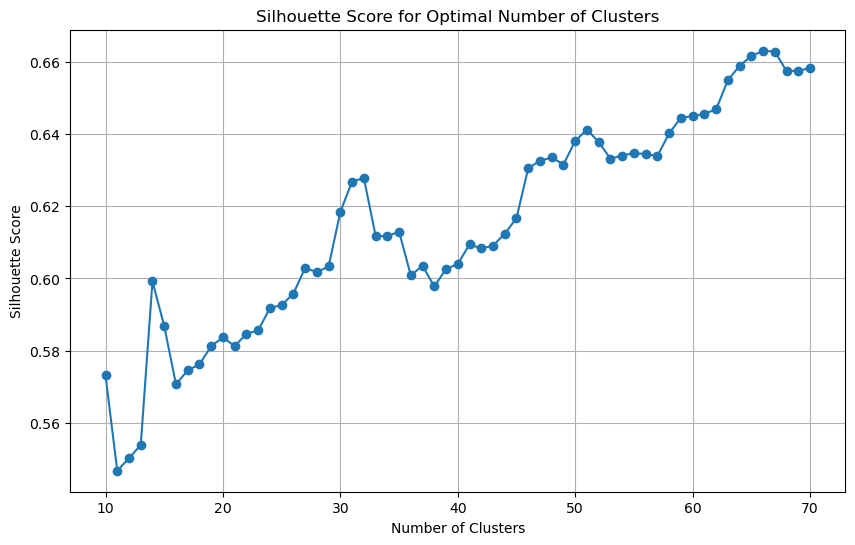

In [ ]:
# silhouette score as alternative method to look at potential number of clusters
from sklearn.metrics import silhouette_score

silhouette_scores = []
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = kmeans.fit_predict(user_vectors)
    silhouette_avg = silhouette_score(user_vectors, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot the Silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal Number of Clusters')
plt.grid(True)
plt.show()

In [ ]:
# running several versions of elbow and silhouette with different cluster ranges (up to 70 clusters)
# leads me to decide to go forward with 25 clusters, as it seems to be a reasonable compromise of good*ish
# scores and a manageable number of clusters

In [ ]:
#  optimal number of clusters determined is 25
optimal_n_clusters = 35

# Fit K-Means model with the chosen number of clusters
kmeans = KMeans(n_clusters=optimal_n_clusters, random_state=0)
user_vectors['cluster'] = kmeans.fit_predict(user_vectors)

In [ ]:
# Get cluster profiles
cluster_profiles = user_vectors.groupby('cluster').mean()
print(cluster_profiles)

           num_pages  ratings_count   biography   children    comics  \
cluster                                                                
0        1365.037086   3.477833e+05    0.828901   0.245124  0.233599   
1        2012.484171   1.646592e+06    1.118250   0.127095  0.058659   
2        1723.632432   2.707530e+06    0.066667   0.090090  0.000000   
3        2008.033333   4.511307e+06    0.000000   3.966667  0.000000   
4        1931.838679   7.715246e+05    0.986635   0.514702  0.271051   
5        1895.793663   1.354209e+06    1.148456   0.154952  0.063365   
6        1434.844813   2.025302e+06    1.211735   0.102891  0.020833   
7        1451.495690   3.741897e+06    0.056034   0.103448  0.000000   
8        2437.317068   9.475791e+05    1.699937   1.289818  0.829531   
9        2515.000000   5.644565e+06    0.000000   5.000000  0.000000   
10       1142.564426   6.107456e+05    0.730392   0.481092  0.177521   
11        749.645579   2.042735e+05    0.236789   0.037348  0.11

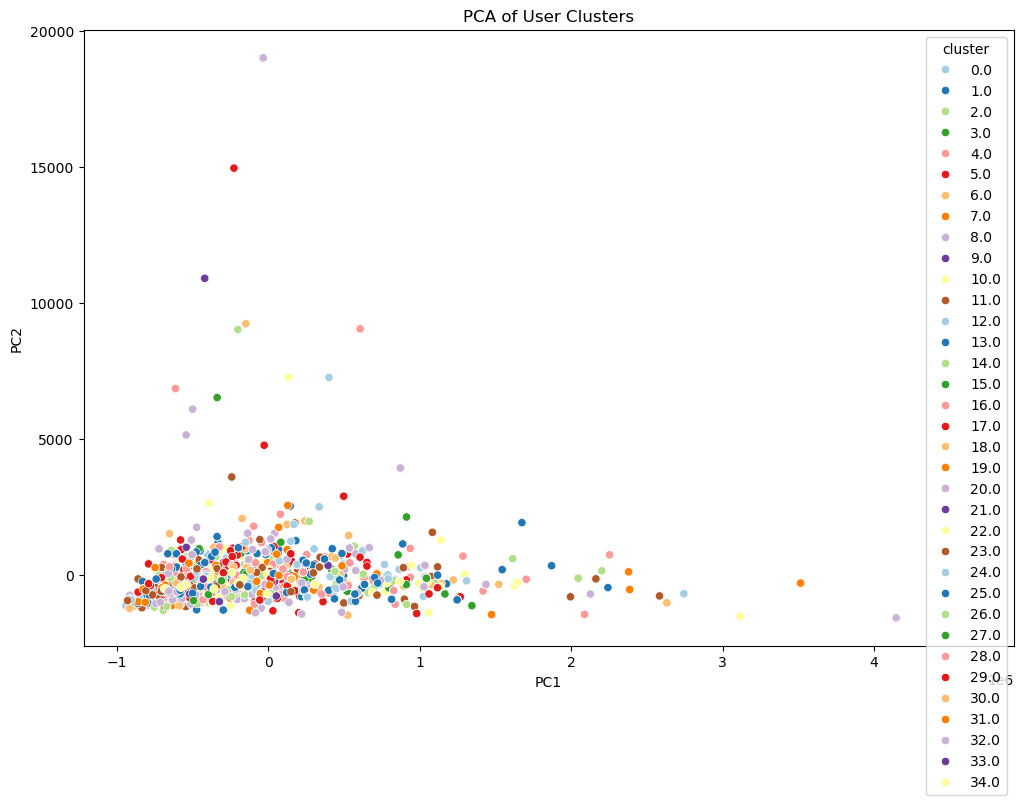

In [ ]:
#initially it was viridis color palette, but that was very monotonic, changed it to Paired, still not very helpful

from sklearn.decomposition import PCA
import seaborn as sns

# Reduce to 2D for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(user_vectors.drop('cluster', axis=1))

# Create a DataFrame for plotting
df_pca = pd.DataFrame(reduced_data, columns=['PC1', 'PC2'])
df_pca['cluster'] = user_vectors['cluster']

# Plot the clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='cluster', palette='Paired', legend='full')
plt.title('PCA of User Clusters')
plt.show()

In [ ]:
# trying out 3d visualization, see if that helps, tried out with 25 clusters, very unsatisfying, trying with 75 clusters, not really helping either
# prepare data for it

from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Perform PCA to reduce to 3D
pca = PCA(n_components=3)
reduced_data = pca.fit_transform(user_vectors.drop('cluster', axis=1))

# Create a DataFrame for plotting
df_pca = pd.DataFrame(reduced_data, columns=['PC1', 'PC2', 'PC3'])
df_pca['cluster'] = user_vectors['cluster']

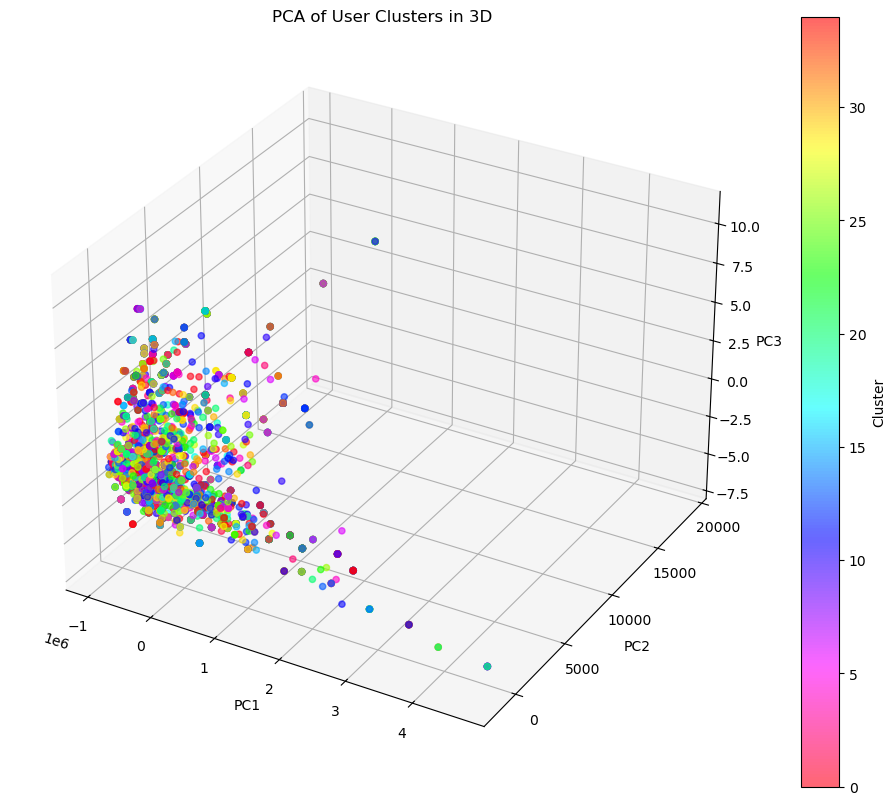

In [ ]:
#create 3D scatter plot, starting with Viridis again

from mpl_toolkits.mplot3d import Axes3D

# Create a 3D scatter plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(df_pca['PC1'], df_pca['PC2'], df_pca['PC3'], 
                     c=df_pca['cluster'], cmap='hsv_r', alpha=0.6)

# Add color bar
cbar = plt.colorbar(scatter)
cbar.set_label('Cluster')

# Labels and title
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('PCA of User Clusters in 3D')

plt.show()

# Overview der vorhandenen Daten im gemergeten Datensatz ´merged_df´

In [54]:
print (merged_df.columns)

Index(['title_x', 'book_id_x', 'user_id_mapping', 'book_id_mapping',
       'Predicted Rating', 'Actual Rating', 'book_id_y', 'title_y',
       'image_url', 'url', 'num_pages', 'ratings_count', 'description', 'name',
       ' biography', ' children', ' comics', ' crime', ' fantasy', ' fiction',
       ' graphic', ' historical fiction', ' history', ' mystery',
       ' nonfiction', ' paranormal', ' poetry', ' romance', ' thriller',
       ' youngadult', 'children', 'comics', 'fantasy', 'fiction', 'mystery',
       'nonfiction', 'poetry', 'romance', 'youngadult'],
      dtype='object')


In [55]:
# inspired by Leas approach to analyze the initial dataset

print(f"Number of observations: {len(merged_df)}")
print(f"Number of unique book ids: {len(merged_df["book_id_x"].unique())}")
print(f"Number of unique user ids: {len(merged_df["user_id_mapping"].unique())}")

print(f"Average actual rating: {merged_df["Actual Rating"].mean()}")
print(f"Average predicted rating: {merged_df["Predicted Rating"].mean()}")

Number of observations: 19824
Number of unique book ids: 95
Number of unique user ids: 17103
Average actual rating: 3.8737893462469732
Average predicted rating: 3.857279055690073


In [73]:
#more analyis
# max numnber of ratings per user and others 
# groupby user id
merged_df_userids=merged_df[["user_id_mapping","book_id_x"]].groupby(by="user_id_mapping").count()
merged_df_userids=merged_df_userids.reset_index()
merged_df_userids=merged_df_userids.rename(columns={"book_id_x":"book_count"})

In [74]:
print(f"(repeat) Number of users: {len(merged_df_userids)}")
print(f"Max number of books revied per user: {merged_df_userids.book_count.max()}")
print(f"Min number of books revied per user: {merged_df_userids.book_count.min()}")
print(f"Number of users with 1 review: {len(merged_df_userids.query('book_count == 1'))}")
print(f"... in %: {round(len(merged_df_userids.query('book_count == 1'))/len(merged_df_userids),2)*100}%") 
print(f"Number of users with 2 review: {len(merged_df_userids.query('book_count == 2'))}")
print(f"... in %: {round(len(merged_df_userids.query('book_count == 2'))/len(merged_df_userids),2)*100}%")
print(f"Number of users with less than 3 reviews: {len(merged_df_userids.query('book_count < 3'))}")
print(f"... in %: {round(len(merged_df_userids.query('book_count < 3'))/len(merged_df_userids),2)*100}%")
print(f"Number of users with more than 1 review: {len(merged_df_userids.query('book_count >1'))}")
print(f"... in %: {round(len(merged_df_userids.query('book_count >1'))/len(merged_df_userids),2)*100}%") #does not limit it to 1 or 2 digits after the comma, how to do that?

(repeat) Number of users: 17103
Max number of books revied per user: 5
Min number of books revied per user: 1
Number of users with 1 review: 14668
... in %: 86.0%
Number of users with 2 review: 2181
... in %: 13.0%
Number of users with less than 3 reviews: 16849
... in %: 99.0%
Number of users with more than 1 review: 2435
... in %: 14.000000000000002%


In [79]:
# group by the user IDs and count the entries per userid
id_counts = merged_df.groupby('user_id_mapping').size()
print(id_counts)

user_id_mapping
2        1
4        1
7        1
21       1
23       1
        ..
84173    1
84179    1
84212    1
84260    1
84282    1
Length: 17103, dtype: int64


In [81]:
# filter for user-ids with 2 or more entries

ids_with_multiple_entries = id_counts[id_counts >= 2].index

# Filter the original DataFrame to only include these IDs
df_filtered = merged_df[merged_df['user_id_mapping'].isin(ids_with_multiple_entries)]
print(ids_with_multiple_entries.shape)
print(df_filtered.shape)

(2435,)
(5156, 39)


In [82]:
#more analyis
# max numnber of ratings per user and others 
# groupby user id

df_filtered_userids=df_filtered[["user_id_mapping","book_id_x"]].groupby(by="user_id_mapping").count()
df_filtered_userids=df_filtered_userids.reset_index()
df_filtered_userids=df_filtered_userids.rename(columns={"book_id_x":"book_count"})

In [83]:
print(f"(repeat) Number of users: {len(df_filtered_userids)}")
print(f"Max number of books revied per user: {df_filtered_userids.book_count.max()}")
print(f"Min number of books revied per user: {df_filtered_userids.book_count.min()}")

(repeat) Number of users: 2435
Max number of books revied per user: 5
Min number of books revied per user: 2


In [89]:
#find out a bit of information about the merged and grouped dataset
#we have a dataframe with 5156 lines with entries of 2435 users that have at least 2 ratings, with that we can try to do some predictions
print(f"Number of users with more than 1 review: {len(df_filtered_userids.query('book_count >1'))}")
print(df_filtered_userids.columns)
print(df_filtered_userids.shape)
print(df_filtered.shape)

Number of users with more than 1 review: 2435
Index(['user_id_mapping', 'book_count'], dtype='object')
(2435, 2)
(5156, 39)
